## 6. Kernelised SVM implemented with NumPy and CVXOPT
The following code contains a kernelised SVM class with linear, rbf and polynomial kernels. below that is a demonstration of the class and its various features in use on some simple datasets.

The equations used in the following code are primarily based on this document:
https://static1.squarespace.com/static/58851af9ebbd1a30e98fb283/t/58902fbae4fcb5398aeb7505/1485844411772/SVM+Explained.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs, make_moons
from cvxopt import matrix, solvers

In [2]:
class SVM():
    """Kernelised hard/soft SVM model - linear, rbf, polynomial"""
    
    def __init__(self, kernel='rbf', C=10, gamma=10, p_const=1, p_deg=2):
        """Set C to False for hard margin"""
        
        self.C = C             #soft margin constant
        self.gamma = gamma     #rbf kernel constant
        self.p_const = p_const #polynomial constant
        self.p_deg = p_deg     #polynomial degree
        self.kernel = kernel
        
        self.kfunc = {
            'linear': self.linear,
            'rbf': self.rbf,
            'polynomial': self.polynomial
        }
        
        self.S_alphas = []
        self.S_index = []
        self.num_S = []
        self.S_vectors = []
        self.S_labels = []
        self.intercept = []
        self.weights = []
        
    def norm(self, x):
        """get the norm for rbf kernel calculation"""
        
        return sum(x.T**2)
        
    def linear(self, x, z):
        """linear kernel"""
        
        return x @ z.T
    
    def rbf(self, x, z):
        """rbf kernel"""
        
        #gamma = 1 / (2 * self.sigma**2)
        
        if z.ndim == 1:
            return np.exp(- self.gamma * ((self.norm(x) + self.norm(z)) - (2 * x @ z.T)))
        else:
            return np.exp(- self.gamma * ((self.norm(x)[:, None] + self.norm(z)) - (2 * x @ z.T)))
    
    def polynomial(self, x, z):
        """polynomial kernel"""
        
        return (x @ z.T + self.p_const)**self.p_deg
    
    def train(self, data, labels):
        """Accepts a num_data by num_features array of data and a 1d array of labels {+1, -1}"""
        
        #data prep for quadratic solver
        n, d = data.shape
        Y = labels[:, None]
        k = self.kfunc[self.kernel](data, data)
        H = (Y @ Y.T) * k

        P = matrix(H*1.)
        q = matrix(-1*np.ones((n, 1)))
        
        if self.C == False: #hard margin
            G = matrix(-1*np.identity(n))
            h = matrix(np.zeros((n, 1)))
        else:            #soft margin
            G = matrix(np.vstack((-1*np.identity(n), np.identity(n))))
            h = matrix(np.vstack((np.zeros((n, 1)), np.ones((n, 1)) * self.C)))
        
        A = matrix(Y.reshape(1, -1)*1.)
        b = matrix(0.)

        #solvers.options['show_progress'] = False
        solve = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(solve['x'])

        S = (alphas > 1e-4).flatten()
        self.S_index = np.arange(data.shape[0])[S]
        self.num_S = sum(S)
        self.S_vectors = data[S]
        self.S_labels = Y[S]
        self.S_alphas = alphas[S]
        
        #calculate intercept
        b = 0
        for i in range(self.num_S):
            b += Y[S][i] - ((Y[S] * alphas[S]).T @ k[self.S_index[i], S])
        self.intercept = b / self.num_S
        
        #calculate weights if linear kernel
        self.weights = ((Y * alphas).T @ data).reshape(-1, 1) if self.kernel == 'linear' else None
        
    def predict(self, data):
        """Accepts a num_data by num_features array of data"""
    
        if self.kernel == 'linear':
            p = data @ self.weights + self.intercept
    
        else:
            z = self.kfunc[self.kernel](self.S_vectors, data)
            p = (z.T @ (self.S_labels * self.S_alphas)) + self.intercept
        
        #np.sign(p) gives the prediction, returns p for the contour plots
        return np.sign(p), p

#### genrating some linearly separable data

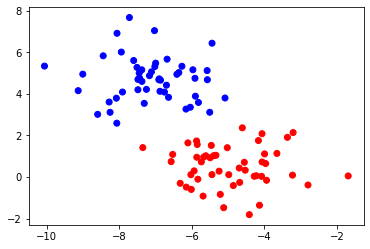

In [3]:
X, y = make_blobs(centers=2, random_state=12)

y[y == 0] = -1

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr)
plt.show()

#### Hard margin linear SVM test

In [4]:
model = SVM(kernel='linear', C=False)

In [5]:
model.train(X, y)

In [6]:
p, _ = model.predict(X)

In [7]:
sum(p == y[:, None]) #all points classified correctly

array([100])

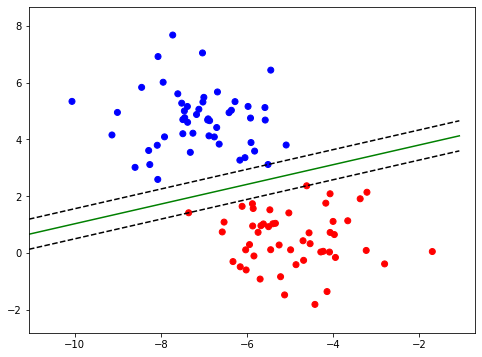

In [8]:
w = model.weights
b = model.intercept
xb = np.arange(min(X[:, 0].flatten()) - 1, max(X[:, 0].flatten()) + 1)
hyp = - (w[0] * xb + b) / w[1]
sv1 = (1 - (w[0] * xb + b)) / w[1]
sv2 = (-1 - (w[0] * xb + b)) / w[1]

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr)
h = ax.plot(xb, hyp, color='g')
sv_pos = ax.plot(xb, sv1, '--k')
sv_neg = ax.plot(xb, sv2, '--k')
ax.set_xlim(min(X[:, 0].flatten()) - 1, max(X[:, 0].flatten()) + 1)
ax.set_ylim(min(X[:, 1].flatten()) - 1, max(X[:, 1].flatten()) + 1)
plt.show()

#### Generating some noisy data for soft margin test

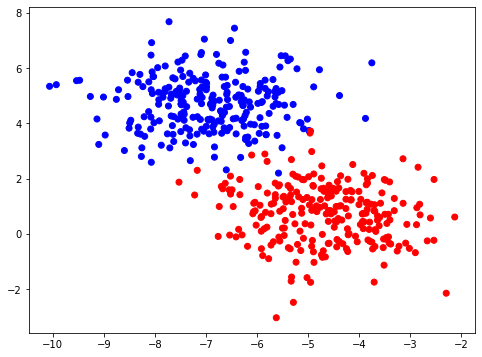

In [9]:
X1, y1 = make_blobs(n_samples=500, centers=2, random_state=12)

y1[y1 == 0] = -1

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X1[:, 0], X1[:, 1], c=y1, cmap=plt.cm.bwr)
plt.show()

#### soft margin linear SVM test

In [10]:
model1 = SVM(kernel='linear', C=0.1)

In [11]:
model1.train(X1, y1)

In [12]:
p1, _ = model1.predict(X1)

In [13]:
sum(p1 == y1[:, None]) #out of 500

array([494])

In [14]:
model1.predict(X1[5]) #single point test

(array([-1.]), array([-1.19766726]))

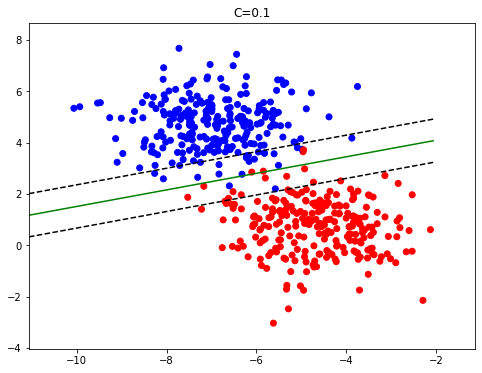

In [15]:
w1 = model1.weights
b1 = model1.intercept
xb1 = np.arange(min(X1[:, 0].flatten()) - 1, max(X1[:, 0].flatten()) + 1)
hyp1 = - (w1[0] * xb1 + b1) / w1[1]
sv11 = (1 - (w1[0] * xb1 + b1)) / w1[1]
sv21 = (-1 - (w1[0] * xb1 + b1)) / w1[1]

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(X1[:, 0], X1[:, 1], c=y1, cmap=plt.cm.bwr)
ax.plot(xb1, hyp1, color='g')
ax.plot(xb1, sv11, '--k')
ax.plot(xb1, sv21, '--k')
ax.set_title('C=0.1')
ax.set_xlim(min(X1[:, 0].flatten()) - 1, max(X1[:, 0].flatten()) + 1)
ax.set_ylim(min(X1[:, 1].flatten()) - 1, max(X1[:, 1].flatten()) + 1)
plt.show()

#### Generating some non-linearly separable data

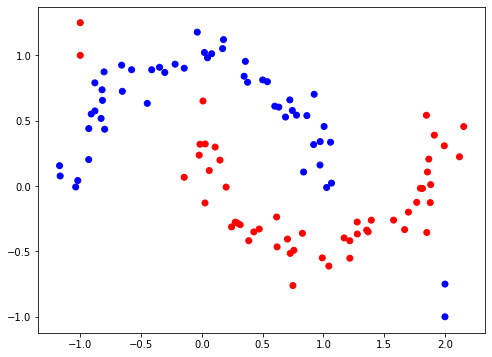

In [16]:
X2, y2 = make_moons(n_samples=100, noise=0.1, random_state=1)

extraX = np.array([-1, 1.25, -1, 1, 2, -1, 2, -0.75]).reshape(4, 2)
extray = np.array([1, 1, -1, -1])

X2 = np.vstack((X2, extraX))
y2 = np.hstack((y2, extray))

y2[y2 == 0] = -1

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(X2[:, 0], X2[:, 1], c=y2, cmap=plt.cm.bwr)
plt.show()

#### rbf kernel SVM test

In [17]:
model2 = SVM(kernel='rbf', C=False, gamma=3)

In [18]:
model2.train(X2, y2)

In [19]:
p2, _ = model2.predict(X2)

In [20]:
sum(p2 == y2[:, None]) #all classified correctly

array([104])

In [21]:
model2.predict(X2[2]) #single point test

(array([-1.]), array([-1.10176859]))

In [22]:
xx, yy = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.5, 1.5, 100))

mesh = np.vstack((np.ravel(xx), np.ravel(yy))).T

z, zp = model2.predict(mesh)
zp = zp.reshape(xx.shape)

#### plot of suppot vectors and boundary 

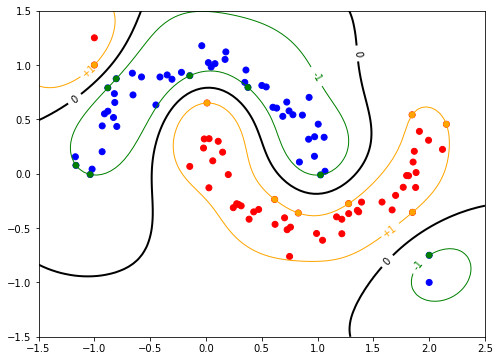

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
color = np.ravel(np.where(model2.S_labels==1, 'orange', 'green'))
ax.scatter(X2[:, 0], X2[:, 1], c=y2, cmap=plt.cm.bwr)
ax.scatter(model2.S_vectors[:, 0], model2.S_vectors[:, 1], c=color, marker='H')

h = ax.contour(xx, yy, zp, [0.0], colors='k', linewidths=2)
S_neg = ax.contour(xx, yy, zp + 1, [0.0],colors='green', linewidths=1)
S_pos = ax.contour(xx, yy, zp - 1, [0.0], colors='orange', linewidths=1)

plt.clabel(h, inline=True, fmt="0")
plt.clabel(S_neg, inline=True, fmt="-1")
plt.clabel(S_pos, inline=True, fmt="+1")
plt.show()

<IPython.core.display.Javascript object>


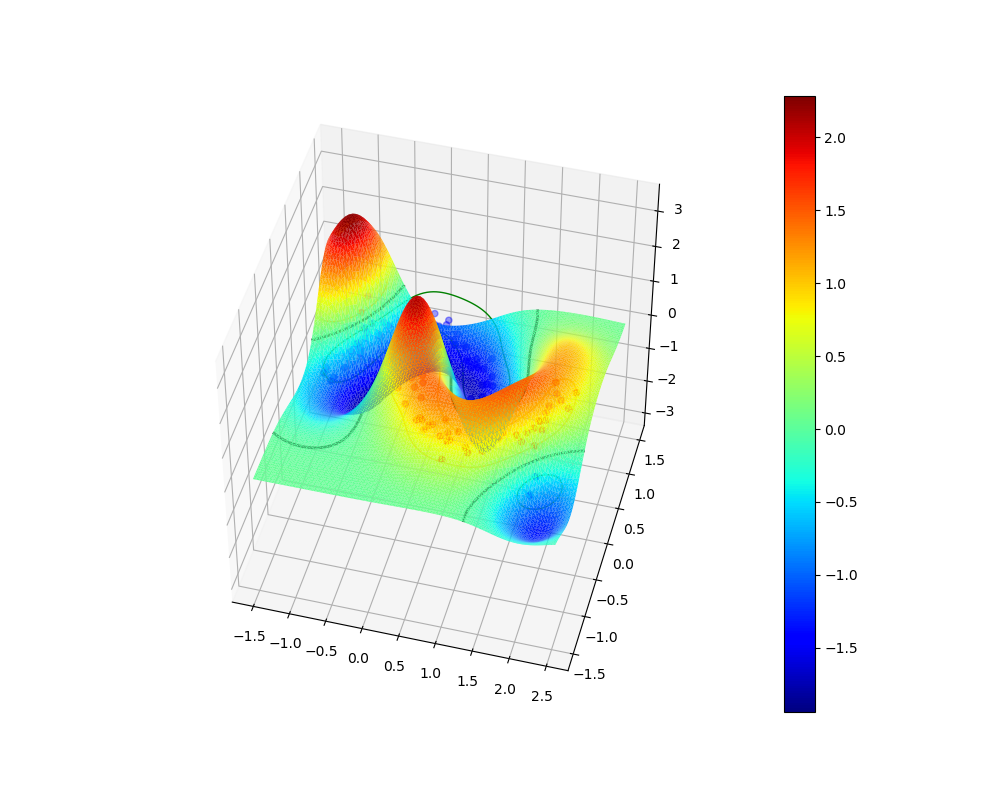

In [32]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(np.ravel(xx), np.ravel(yy), np.ravel(zp), cmap=plt.cm.jet)
fig.colorbar(surf)

color = np.ravel(np.where(model2.S_labels==1, 'orange', 'green'))
ax.scatter(X2[:, 0], X2[:, 1], c=y2, cmap=plt.cm.bwr)
ax.scatter(model2.S_vectors[:, 0], model2.S_vectors[:, 1], c=color, marker='H')

h = ax.contour(xx, yy, zp, [0.0], colors='k', linewidths=2)
S_neg = ax.contour(xx, yy, zp + 1, [0.0],colors='green', linewidths=1)
S_pos = ax.contour(xx, yy, zp - 1, [0.0], colors='orange', linewidths=1)

plt.clabel(h, inline=True, fmt="0")
plt.clabel(S_neg, inline=True, fmt="-1")
plt.clabel(S_pos, inline=True, fmt="+1")
plt.show()

#### polynomial kernel test on the same data

In [25]:
model3 = SVM(kernel='polynomial', C=False, p_const=1, p_deg=5)

In [26]:
model3.train(X2, y2)

In [27]:
p3, _ = model3.predict(X2)

In [28]:
sum(p3 == y2[:, None])

array([104])

In [29]:
model3.predict(X2[2])

(array([-1.]), array([-0.99992859]))

In [30]:
xx2, yy2 = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1.5, 1.5, 100))

mesh2 = np.vstack((np.ravel(xx2), np.ravel(yy2))).T

z2, zp2 = model3.predict(mesh2)
zp2 = zp2.reshape(xx2.shape)

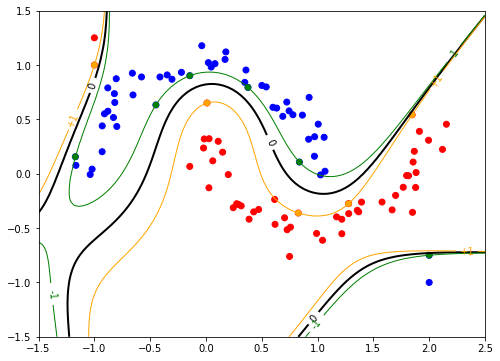

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
color = np.ravel(np.where(model3.S_labels==1, 'orange', 'green'))
ax.scatter(X2[:, 0], X2[:, 1], c=y2, cmap=plt.cm.bwr)
ax.scatter(model3.S_vectors[:, 0], model3.S_vectors[:, 1], c=color, marker='H')

h2 = ax.contour(xx2, yy2, zp2, [0.0], colors='k', linewidths=2, origin='lower')
S_neg2 = ax.contour(xx2, yy2, zp2 + 1, [0.0],colors='green', linewidths=1, origin='lower')
S_pos2 = ax.contour(xx2, yy2, zp2 - 1, [0.0], colors='orange', linewidths=1, origin='lower')

plt.clabel(h2, inline=True, fmt="0")
plt.clabel(S_neg2, inline=True, fmt="-1")
plt.clabel(S_pos2, inline=True, fmt="+1")
plt.show()